<h1 style="text-align: center;">Rip Current Data Analysis</h1>

This notebook is created to show the functions used for analyzing rip current data and associated environmental data. 

The rip current detection data is saved as a dictionary, which keys is the timestamp string of format "YYYY-MM-DD-hh-mm-ss", the items inside are "bboxes" of topleft and bottomright x,y coordinates, and "pvals" of the p-values corresponding to each boxes. 

The rip current event data is processed and saved as a list of dictionary, the dictionary has many key-items, such as max_dist, start_time, end_time, duration, etc.

First, import the required libraries.

In [9]:

from Utils.Box.BoxProcessing import compute_center_points, compute_max_dist, split_events_based_on_max_dist, convert_box_dict_to_series 
from Utils.XML.xmlProcessing import parse_xml, process_xml_folder, merge_boxes 
from Utils.DateTime.BasicDateTime import convert_and_sort_datetime_index, convert_data_to_pd_dict_within_range,\
                                         convert_missing_datetime_to_time, convert_missing_match_to_list, convert_utc_to_central,\
                                            modify_values_outside_hours, get_daily_ratio_values
from Utils.SideFunc.seriesPlotting import  draw_multibarplots, plot_3d_stacked_bar, plot_contour_map, \
                                        draw_multibarplots_with_category_V2
from Utils.Wave.station1 import TimeDomain, WaveInformationStudy
from Utils.Wave.main import main_wave, parse_args
from Utils.Wave.wave_processing import extract_data_of_time_interval, get_all_candidate_time, get_wave_data_column, weighted_average_angle,\
                                        add_new_wave_data_column, get_binary_columns, convert_wave_data_into_dict, update_with_wave_routing,\
                                        add_routing_to_wave_data, add_missing_to_wave_data, update_with_wave_depth_routing
from Utils.Wave.physical_process import wave_routing_by_depth
from Utils.Angles.angleProcessing import dms_to_dec, calculate_azimuth
from Utils.WaterLevel.WSLProcessing import PreprocessWSLDF, compute_WLF, convert_WSL_pd_to_dict, add_WLF_to_rip_dict
from Utils.Wind.wind_processing import read_wind_data_V2, linear_regress_columns, read_wind_data_V3
from Utils.SideFunc.dataInteraction import interpolate_values, get_subdictionary_keys, process_data_within_range, create_hist_data,\
                                             interpolate_vals, compute_weight, resample_data, print_log_for_hist_data, get_bar_data,\
                                            process_data_within_range_for_classes, analyze_cross_relationship, find_bin_ind,\
                                            generate_bin_ticks, dict_list_to_dataframe, convert_pd_to_dict
from Utils.SideFunc.timeSeriesAnalysis import highpass_filter, process_zero_crossing, insert_missing_timestamps
from Utils.Box.RipOperation import track_rip_boxes, eliminate_short_rips, merge_rip_dict_with_other_data, eliminate_xposition_events,\
                                    keep_daytime_events, add_classification_col, add_classification_col_V2, eliminate_small_dist_events,\
                                    update_classification, get_max_box_list,eliminate_long_duration_events
from Utils.Wave.wave_physical_process import new_wave_routing, wave_routing
from Utils.Wave.wave_config import wave_config
import Utils.SideFunc.multiPlotting as mdp
import sys, os, pickle, copy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import math
from datetime import datetime, timedelta, time
from collections import defaultdict
import pytz
import netCDF4 as nc
from tqdm import tqdm
import seaborn as sns
# import multidataplotting as mdp
import timestampprocessing as tsp
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Then, load the model detection result, which include the detection results from deep learning model.

In [2]:
'''
Load rip current data detected from DL model (The whole image result)
'''
model_detection_path = r'F:/Dropbox/Prelim/Code_And_Data/chapter4/Data/Detection/Whole_Img_Events_2019-05-15_2019-09-14.pckl'
# if we do not consider the averaging of temp boxes at each timestamp, then use the following path 
# model_detection_path = r'F:\ResearchProjects\RIPCODES\RipProject\RipModelRes\Whole_Img_Events_2019-05-15_2019-09-14_V3.pckl'
with open(model_detection_path, 'rb') as f:
    whole_img_events = pickle.load(f)
f.close()


Then, we load the wave data from wave information study.

In [3]:
'''
This cell is for reading the wave height and angle data from WaveInformationStudy sites
We use the wave_config class to create arguments to read the wave data from the wave folder for the station name and the time interval
The main_wave function is used to read the wave data from the wave folder and return the station object
The station object contains the wave data in the form of pandas series for the wave height, period, and angle
The timestamps are also stored in the form of pandas series
The wave data is then converted into a dictionary with the timestamp as the key and the wave height, period, and angle as the values
The timestamp is converted into a list of datetime objects

'''
sys.argv=['']
wave_folder = 'F:/ResearchProjects/RIPCODES/Wave_data/'
station_name = 'ST94058'
wave_start_year, wave_start_month, wave_start_day = 2019, 5, 1
wave_end_year, wave_end_month, wave_end_day = 2019, 10, 31
args = wave_config(wave_start_year, wave_start_month, wave_start_day, wave_end_year, wave_end_month, wave_end_day, wave_folder, station_name)
station = main_wave(args)
hs = station.hs_series
period = station.period_series
angle = station.angle_series
timestamps = station.time_series
lat_arr1, lat_arr2, lon_arr1, lon_arr2 = [43, 23, 36], [
        43, 24, 0], [-87, 51, 50], [-87, 51, 30]
coord_1, coord_2 = (dms_to_dec(lat_arr1[0], lat_arr1[1], lat_arr1[2]),
        dms_to_dec(lon_arr1[0], lon_arr1[1], lon_arr1[2])),\
        (dms_to_dec(lat_arr2[0], lat_arr2[1], lat_arr2[2]),
        dms_to_dec(lon_arr2[0], lon_arr2[1], lon_arr2[2]))
azimuth = calculate_azimuth(coord_1, coord_2)
wave_preload = True;
if wave_preload:
    pickle_folder = 'F:/Dropbox/Prelim/Code_And_Data/chapter4/Data/Pickle/';
    with open(pickle_folder + 'wave_data1.pckl', 'rb') as f:
        wave_data = pickle.load(f)
        f.close()
else:
    wave_data = convert_wave_data_into_dict(timestamps, angle, hs, period, azimuth, convert_timezone = True)
    timestamp_list = convert_and_sort_datetime_index(timestamps)
    wave_data = add_routing_to_wave_data(wave_data,offshore_depth = 44, kb = 0.8, target_depth=2)


Now, load the water level flucutuation results downloaded from buoys and processed by a matlab script. Also, we need to load the dictionary records the timestamps that are missed in the ortho-image dataset. After operating this cell, whole_WSL_df is a dataframe that is indexed by Datetime, the two columns are WSL, which is the orig WSL value, and filtered_WSL, which is the WSL value after high-pass filtering.

In [4]:
WSL_path = r'F:\ResearchProjects\RIPCODES\RipProject\WaterLevelData\Filtered_Data\filtered_WSL.csv'
whole_WSL_df = pd.read_csv(WSL_path)
whole_WSL_dict = convert_WSL_pd_to_dict(whole_WSL_df)
whole_WSL_timestamps = list(whole_WSL_dict.keys())
missing_data_file = r'F:\ResearchProjects\RIPCODES\RipProject\MissingData\missing_data.pckl'
with open(missing_data_file, 'rb') as f:
    missing_data = pickle.load(f)
f.close()
whole_WSL_df = PreprocessWSLDF(whole_WSL_df, is_convert_time_zone = True)
whole_WSL_df.set_index('Datetime', inplace=True) 


This cell read and processed the wind data, for the preesure data along with wind station, we applied high-pass filter. Also, we make the wind data indexed as timestamp as well.

In [5]:
is_load_wind_df = True
wind_choice = 3

if wind_choice == 2:
    cutoff_frequency = 1/(3600 * 6)  # Cutoff frequency in Hz (SET TO BE 2HR)
    sampling_interval = 60*20  # Calculate the sampling interval in seconds (20 MIN)
    columns_to_filter = ['sknt', 'alti']
elif wind_choice == 3:
    cutoff_frequency = 1/(3600 * 6)  # Cutoff frequency in Hz (SET TO BE 2HR)
    sampling_interval = 60# Calculate the sampling interval in seconds (20 MIN)
    columns_to_filter = ['pres1_MKE_Pres1', 'pres2_MKE_Pres2', 'pres3_MKE_Pres3']

if is_load_wind_df:
    wind_df_path = r'F:/ResearchProjects/RIPCODES/RipProject/WindData/ASOS_MKE.pckl'
    wind_df = pickle.load(open(wind_df_path, 'rb'))
else:    
    # 1 FOR PWAW, 2 FOR ETB, 3 FOR ASOS
    if wind_choice == 2:
        wind_folder, wind_file = 'F:/ResearchProjects/RIPCODES/RipProject/WindData/', 'ETB_MWC.csv'
        skip_first_row, is_interpolate, is_adjust_time, is_convert_time_zone = True, True, True, True
        is_convert_from_knot, is_convert_from_iiHg = True, True
        file_path = os.path.join(wind_folder, wind_file)
        columns_to_interpolate = ['sknt', 'alti', 'drct']
        start_time_0, end_time_0 = pd.Timestamp('2019-04-01 00:00:00'), pd.Timestamp('2019-10-31 12:00:00')
        use_cols = ['valid', 'sknt', 'gust', 'drct', 'alti']
        is_linear_regression = False

        wind_props = {
                    'skip_first_row': skip_first_row, 'is_interpolate': is_interpolate,
                    'is_convert_from_knot': is_convert_from_knot,
                    'is_convert_from_iiHg': is_convert_from_iiHg,
                    'is_convert_time_zone': is_convert_time_zone, 
                    'cols_to_interpolate': columns_to_interpolate,
                    'start_time': start_time_0, 'end_time': end_time_0, 
                    'is_adjust_time': is_adjust_time, 'use_cols': use_cols
                    }
        wind_df = read_wind_data_V2(wind_folder, wind_file, **wind_props)

        if is_linear_regression:
            target_column = 'gust'  # This is the column with missing values you want to fill
            predictor_columns = ['sknt', 'alti', 'drct']  # These columns are used as predictors
            wind_df = linear_regress_columns(wind_df, predictor_columns, target_column)
        
                
    elif wind_choice == 3:
        folder_path = "F:/ResearchProjects/RIPCODES/ASOS/MKE/"
        prefix = "MKE"
        suffix = ".txt"
        is_insert_missing = False
        wind_df = read_wind_data_V3(folder_path, prefix, suffix)
        
        if is_insert_missing:
            wind_df = insert_missing_timestamps(wind_df)

for c in tqdm(columns_to_filter):
    if wind_df[c].isna().any():
        print('a')
        wind_df[c] = wind_df[c].replace('M', np.nan).astype(float)
        wind_df[c] = wind_df[c].interpolate()
        
    filtered_data = highpass_filter(wind_df[c], cutoff_frequency, 1 / sampling_interval)
    wind_df['filtered_' + c] = filtered_data
new_wind_data = {}
new_wind_columns = list(wind_df.columns)
wind_len = len(wind_df)
for i in tqdm(range(wind_len)):
    temp_key = pd.to_datetime(wind_df.index[i]).strftime('%Y-%m-%d-%H-%M-%S')
    temp_items = {}
    for wc in new_wind_columns:
        temp_items[wc] = wind_df[wc].iloc[i]
    new_wind_data[temp_key] = temp_items


100%|██████████| 281695/281695 [00:18<00:00, 15451.10it/s]


In this cell, we calculated the zero-crossing fluctuations of water level and pressure.

In [11]:
start_date = pd.Timestamp('2019-05-01')
end_date = pd.Timestamp('2019-10-15')
interval_b = 60 * 6
WSL_series = whole_WSL_df['filtered_WSL']
WSL_crossed_series = process_zero_crossing(WSL_series, start_date, end_date, interval_b)
wind_speed_series, wind_alti_series = wind_df['sknt_MKE_WindSpeed'].astype(float), wind_df['filtered_pres1_MKE_Pres1'].astype(float)
wind_speed_crossed_series = process_zero_crossing(wind_speed_series, start_date, end_date, interval_b)
wind_alti_crossed_series = process_zero_crossing(wind_alti_series, start_date, end_date, interval_b)
whole_wind_crossed_df = pd.concat([wind_speed_crossed_series, wind_alti_crossed_series], axis=1)
whole_wind_crossed_df.columns = ['Crossed_Wind_Speed', 'Crossed_Wind_Alti']
whole_WSL_crossed_df = WSL_crossed_series.to_frame(name = 'Crossed_WSL')
whole_wind_crossed_df.dropna().sort_index()
whole_WSL_crossed_df.dropna().sort_index()

f:\Dropbox\Prelim\Code_And_Data\chapter4\Utils\SideFunc\timeSeriesAnalysis.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_series = pd.Series(index=pd.date_range(start=start_date, end=end_date, freq=series.index.freq))


,Crossed_WSL
2019-05-01 00:00:00,1.019873
2019-05-01 00:06:00,1.019873
2019-05-01 00:12:00,1.019873
2019-05-01 00:18:00,1.019873
2019-05-01 00:24:00,1.019873
...,...
2019-10-13 17:36:00,0.353192
2019-10-13 17:42:00,0.353192
2019-10-13 17:48:00,0.353192
2019-10-13 17:54:00,0.353192


In [12]:

# use convert pd to dict if the pd is indexed by timestamp
whole_wind_crossed_data, whole_WSL_crossed_data = convert_pd_to_dict(whole_wind_crossed_df), convert_pd_to_dict(whole_WSL_crossed_df)

Index(['Crossed_Wind_Speed', 'Crossed_Wind_Alti'], dtype='object')
Index(['Crossed_WSL'], dtype='object')


In [13]:
from datetime import datetime, timedelta
from Utils.DateTime.BasicDateTime import find_closest_timestamps

def merge_rip_dict_with_other_data(daily_event_list, other_dict, other_interval, other_keys, 
                                   start_time_str=None, range_limited=True, lag_time=0):
    daily_num = len(daily_event_list)
    res = []
    time_offset = timedelta(hours=lag_time)
    time_format = "%Y-%m-%d-%H-%M-%S"
    
    for i in range(daily_num):
        temp_event = daily_event_list[i]
        
        # Parse and shift timestamps
        adj_start_time = datetime.strptime(temp_event.get('start_time'), time_format) - time_offset
        adj_end_time = datetime.strptime(temp_event.get('end_time'), time_format) - time_offset
        adj_peak_time = datetime.strptime(temp_event.get('peak_time'), time_format) - time_offset

        # Convert back to string if needed by helper functions
        adj_start_str = adj_start_time.strftime(time_format)
        adj_end_str = adj_end_time.strftime(time_format)
        adj_peak_str = adj_peak_time.strftime(time_format)

        # Find closest timestamps
        start_low_timestamp, start_high_timestamp = find_closest_timestamps(adj_start_str, other_interval, start_time_str=start_time_str)
        end_low_timestamp, end_high_timestamp = find_closest_timestamps(adj_end_str, other_interval, start_time_str=start_time_str)
        peak_low_timestamp, peak_high_timestamp = find_closest_timestamps(adj_peak_str, other_interval, start_time_str=start_time_str)

        # Compute weights
        start_weight = compute_weight(adj_start_str, start_low_timestamp, start_high_timestamp)
        end_weight = compute_weight(adj_end_str, end_low_timestamp, end_high_timestamp)
        peak_weight = compute_weight(adj_peak_str, peak_low_timestamp, peak_high_timestamp)

        for k in other_keys:
            if k.lower() in ['direction', 'angle']:
                temp_event['Start_' + k] = weighted_average_angle(
                    other_dict[start_low_timestamp][k],
                    other_dict[start_high_timestamp][k],
                    start_weight,
                    range_limited=range_limited
                )
                temp_event['End_' + k] = weighted_average_angle(
                    other_dict[end_low_timestamp][k],
                    other_dict[end_high_timestamp][k],
                    end_weight,
                    range_limited=range_limited
                )
                temp_event['Peak_' + k] = weighted_average_angle(
                    other_dict[peak_low_timestamp][k],
                    other_dict[peak_high_timestamp][k],
                    peak_weight,
                    range_limited=range_limited
                )
            else:
                temp_event['Start_' + k] = interpolate_vals(
                    other_dict[start_low_timestamp][k],
                    other_dict[start_high_timestamp][k],
                    start_weight
                )
                temp_event['End_' + k] = interpolate_vals(
                    other_dict[end_low_timestamp][k],
                    other_dict[end_high_timestamp][k],
                    end_weight
                )
                temp_event['Peak_' + k] = interpolate_vals(
                    other_dict[peak_low_timestamp][k],
                    other_dict[peak_high_timestamp][k],
                    peak_weight
                )

        res.append(temp_event)
    
    return res



The following cell merges all of above results, to be a final_res, which is a list of dictionary, containing different events.

In [21]:
final_res = []
for i in whole_img_events.keys():
    temp_events = whole_img_events.get(i)
    event_num = len(temp_events)
    if event_num == 0:
        continue
    else:
        # print(temp_events[0])
        wave_check_keys = get_subdictionary_keys(wave_data)
        WSL_check_keys = get_subdictionary_keys(whole_WSL_dict)
        wave_check_interval = 3600
        WSL_check_interval = 360
        wind_check_interval = 60
        wind_check_keys = ['gust_drct_MKE_GustDir', 'gust_sknt_MKE_GustSpeed', 'pres1_MKE_Pres1',
       'pres2_MKE_Pres2', 'pres3_MKE_Pres3', 'vis1_coeff_MKE_Vis1',
       'vis2_coeff_MKE_Vis2', 'vis3_coeff_MKE_Vis3', 'drct_MKE_WindDir',
       'sknt_MKE_WindSpeed', 'filtered_pres1_MKE_Pres1', 'filtered_pres2_MKE_Pres2', 'filtered_pres3_MKE_Pres3']
        wind_start_time = '2019-03-31-19-15-00'
        temp_merged_res = merge_rip_dict_with_other_data(temp_events, wave_data, wave_check_interval, wave_check_keys, range_limited = False, lag_time=0.5)
        temp_merged_res = merge_rip_dict_with_other_data(temp_merged_res, whole_WSL_dict, WSL_check_interval, WSL_check_keys)
        temp_merged_res = merge_rip_dict_with_other_data(temp_merged_res, new_wind_data, wind_check_interval, wind_check_keys, start_time_str = wind_start_time)
        crossed_wind_start_time = '2019-05-01-00-15-00'
        crossed_WSL_start_time = '2019-05-01-00-00-00'
        
        temp_merged_res = merge_rip_dict_with_other_data(temp_merged_res, whole_wind_crossed_data,\
                                                         1200, ['Crossed_Wind_Speed', 'Crossed_Wind_Alti'], start_time_str = crossed_wind_start_time)
        temp_merged_res = merge_rip_dict_with_other_data(temp_merged_res, whole_WSL_crossed_data,\
                                                         360, ['Crossed_WSL'], start_time_str = crossed_WSL_start_time)
        final_res = final_res + temp_merged_res

final_res = add_WLF_to_rip_dict(final_res, whole_WSL_dict, WSL_check_interval)

# timestamp_hist = get_time_range_histogram_data(final_res, '05-00-00', '21-00-00')
# plot_time_histogram(timestamp_hist, is_show = True)

final_res = eliminate_xposition_events(final_res, 250)
final_res = eliminate_small_dist_events(final_res, 100)
final_res = eliminate_long_duration_events(final_res, 3600)
# timestamp_hist = get_time_range_histogram_data(final_res, '05-00-00', '21-00-00')
# plot_time_histogram(timestamp_hist, is_show = True)

final_res = keep_daytime_events(final_res, '08-00-00', '18-00-00')

# add classification column
final_res = add_classification_col(final_res, 60, 120, 0.3048)
# final_res = eliminate_xposition_events(final_res, 3750, is_left = False)

In [ ]:
final_res = update_with_wave_depth_routing(final_res, compute_timestamp='Peak', bottom_slope = 0.028, kb = -999, steps=6000,target_depth=2)
final_res = add_classification_col_V2(final_res, -30, 30, key = 'nearshore_height', key_thresh = 0.4)
final_res = update_classification(final_res, angle_1 = -30, angle_2 = 30, thresh=0.3, ratio=0.3014)
sum([i['nearshore_height'] < 0.3 for i in final_res])
sum_height = np.sum([i['nearshore_height'] if i['breaking_dist'] >= 0 else 0 for i in final_res])
mean_height = np.mean([1 if i['breaking_dist'] >= 0 else 0 for i in final_res])
print(sum_height, mean_height)
missing_timestamps = convert_missing_datetime_to_time(missing_data)
missing_results = tsp.find_missing_ranges(missing_timestamps, interval=15)  # 15 seconds interval

raw_missing_list = convert_missing_match_to_list(missing_results)
missing_list = tsp.merge_close_ranges(raw_missing_list)

total_start, total_end = datetime(2019, 5, 15, 0, 0, 0), datetime(2019, 9, 14, 23, 59, 59)
nonmissing_list = tsp.find_non_missing_timestamps(total_start, total_end, missing_list, interval_seconds=15)



100%|██████████| 1897/1897 [01:15<00:00, 25.24it/s] 


602.4872357590268 0.8429098576700053


[607, 578, 598, 114]
[0.319978914074855, 0.3046916183447549, 0.3152345809172377, 0.060094886663152346]


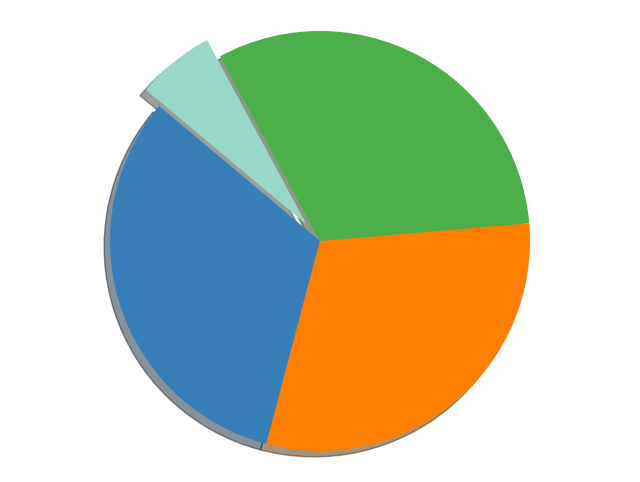

In [54]:
# Now we want to save final_res to a file for future use.
is_save_final_res = False
is_load_final_res = True
# sensitivity params are wave_right_boundary, which is the right boundary of waves, default: group_2 is 0.3, left: group_1 is 0.25, right: group_3 is 0.35;
#                        angle_range, which is the angle angle for identifying normal waves, default: group_2, -45 to 45, left: group_1, -40 to 40; right: group_3: -50 to 50;
#                        bottom_slope, which is the bottom slope, default: group_2, 0.028, left: group_1, 0.025, right:group_3, 0.03.
sensitivity_params = ["wave_right_boundary", "angle_range", "target_depth"]
group_num = 2
save_folder = "F:/Dropbox/Prelim/Code_And_Data/chapter4/Data/Pickle/"
save_name = "final_res_2019-05-15_2019-09-13-%s-%d"%(sensitivity_params[1], group_num);
os.makedirs(save_folder, exist_ok=True)
if is_save_final_res:
    with open(save_folder + save_name, 'wb') as f:
        pickle.dump(final_res, f)
    f.close()
if is_load_final_res:
    with open(save_folder + save_name, 'rb') as f:
        final_res = pickle.load(f)
    f.close()    

WLF_final_res = [i for i in final_res if i.get('Classification_V3') == 1]
Oblique_final_res = [i for i in final_res if i.get('Classification_V3') == 3]
Normal_final_res = [i for i in final_res if i.get('Classification_V3') == 2]
Other_final_res = [i for i in final_res if i.get('Classification_V3') == 4]
labels = '', '', '', ''
sizes = [len(WLF_final_res), len(Normal_final_res), len(Oblique_final_res), len(Other_final_res)]  # Your three integers
print(sizes)
#print percent
print([i/sum(sizes) for i in sizes])
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9']
explode = (0, 0, 0, 0.1)  # explode 2nd slice (i.e., 'B')

# Plotting the pie chart
plt.figure(figsize=(8, 6))
# plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.show()

In [33]:
new_wave_data = add_missing_to_wave_data(wave_data, missing_data)
new_wave_data = add_routing_to_wave_data(new_wave_data)

100%|██████████| 1229/1229 [01:31<00:00, 13.42it/s]


In [35]:
def select_data_between_range(hist_list, thresh_1, thresh_2):
    if thresh_1 == None:
        thresh_1 = -999999
    if thresh_2 == None:
        thresh_2 = 999999
    new_hist_list = []
    for i in hist_list:
        new_hist_list.append([j for j in i if j >= thresh_1 and j <= thresh_2])
    return new_hist_list



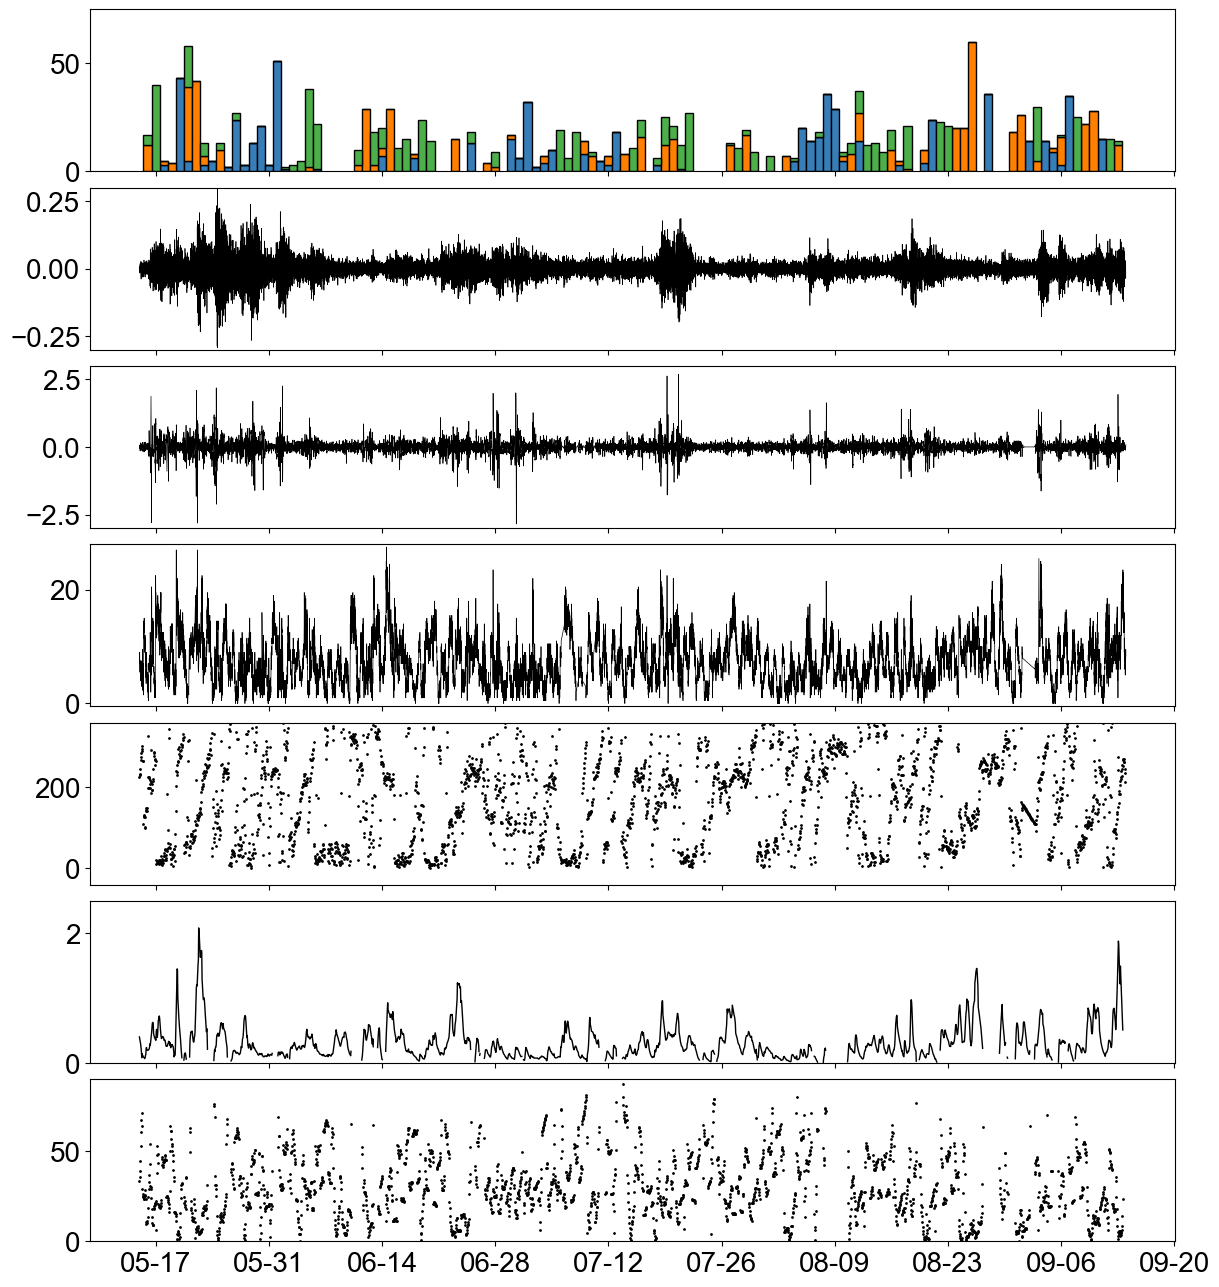

In [37]:
event_plot_properties = {"bar_color": '#66bd63', 
                   "bar_thickness": 1, 
                   "bar_edge_color": "black", 
                   "y_range": [(0, 65), (0, 2), (-40, 340), (-0.3, 0.3)],
                   "figsize": (12, 8), 
                   "tick_fontsize": 12,
                   "tick_fontname": "Arial", 
                   "x_tick_interval": 7,
                   'line_color': 'black',
                   'line_thickness':[1,1,0.1],
                   'is_show': False,
                   'save_path': save_folder + 'flash_rip_event_ts_plot.png'}

daily_count_res = process_data_within_range(final_res, '2019-05-15', '2019-09-13', '', 'sum')
daily_class_count_res = process_data_within_range_for_classes(final_res, '2019-05-15', '2019-09-13', class_column = 'Classification_V3')
# wave_dir_in_range = convert_data_to_pd_dict_within_range(wave_data, 'direction', '2019-05-15-00-00-00', '2019-09-13-23-59-59')
# wave_height_in_range = convert_data_to_pd_dict_within_range(wave_data, 'height', '2019-05-15-00-00-00', '2019-09-13-23-59-59')
wave_dir_in_range = convert_data_to_pd_dict_within_range(wave_data, 'nearshore_angle', '2019-05-15-00-00-00', '2019-09-13-23-59-59')
wave_height_in_range = convert_data_to_pd_dict_within_range(wave_data, 'nearshore_height', '2019-05-15-00-00-00', '2019-09-13-23-59-59')

# Index(['gust_drct_MKE_GustDir', 'gust_sknt_MKE_GustSpeed', 'pres1_MKE_Pres1',
#        'pres2_MKE_Pres2', 'pres3_MKE_Pres3', 'vis1_coeff_MKE_Vis1',
#        'vis2_coeff_MKE_Vis2', 'vis3_coeff_MKE_Vis3', 'drct_MKE_WindDir',
#        'sknt_MKE_WindSpeed'],
#       dtype='object')

resampled_wind_dict = resample_data(new_wind_data, 60, 360)
wind_dir_in_range = convert_data_to_pd_dict_within_range(resample_data(new_wind_data, 60, 3600), 'drct_MKE_WindDir', '2019-05-15-00-00-00', '2019-09-13-23-59-59')
wind_speed_in_range = convert_data_to_pd_dict_within_range(resampled_wind_dict, 'sknt_MKE_WindSpeed', '2019-05-15-00-00-00', '2019-09-13-23-59-59')
pressure_in_range = convert_data_to_pd_dict_within_range(resampled_wind_dict, 'filtered_pres1_MKE_Pres1', '2019-05-15-00-00-00', '2019-09-13-23-59-59')
resampled_WSL_dict = resample_data(whole_WSL_dict, 360,360)
WSL_in_range = convert_data_to_pd_dict_within_range(resampled_WSL_dict, 'filtered_WSL', '2019-05-15-00-00-00', '2019-09-13-23-59-59', is_feet = True)
# draw_multibarplots(daily_count_res, [wave_height_in_range, wave_dir_in_range, WSL_in_range], **event_plot_properties)

remove_nan = True
wave_dir_ratio_in_range = get_daily_ratio_values(wave_dir_in_range)

cat_event_plot_properties = {
                   "bar_thickness": 1, 
                   "bar_edge_color": "black", 
                   "y_range": [(0, 75), (-0.3, 0.3), (-3, 3), (-0.5, 28), (-40, 360), (0, 2.5), (0, 90)],
                   "fig_size": (14, 16), 
                   "tick_fontsize": 20,
                   "tick_fontname": "Arial", 
                   "x_tick_interval": 14,
                   'line_color': 'black',
                   'line_thickness':[0.5,0.5,0.5, 0,1, 0],
                   'is_show': False,
                   'cat_labels': ['WLF', 'NW', 'OW'],
                   'rotation': 0,
                   'is_legend': False,
                   'save_path': save_folder + 'flash_rip_event_ts_cat_plot.png'}

if not remove_nan:
    data_list = [WSL_in_range, pressure_in_range, wind_speed_in_range, wind_dir_in_range, wave_height_in_range, wave_dir_in_range]
else:
    data_list = [modify_values_outside_hours(WSL_in_range), modify_values_outside_hours(pressure_in_range), modify_values_outside_hours(wind_speed_in_range), 
                 modify_values_outside_hours(wind_dir_in_range), modify_values_outside_hours(wave_height_in_range), modify_values_outside_hours(wave_dir_in_range)]
mdp.draw_cat_bar_curveplots(daily_class_count_res,  [WSL_in_range, pressure_in_range, wind_speed_in_range, 
                                                     wind_dir_in_range, wave_height_in_range, wave_dir_in_range],
                                   **cat_event_plot_properties)

# draw_multibarplots_with_category_V2(daily_class_count_res, [wave_height_in_range, wave_dir_in_range, WSL_in_range, wind_dir_in_range, wind_speed_in_range, pressure_in_range], missing_list = None,
#                                   non_missing_list = None, **cat_event_plot_properties)


In [38]:
modified_WSL_in_range = modify_values_outside_hours(WSL_in_range)

Figure saved to F:/ResearchProjects/RIPCODES/RipProject/Plots/Precision1.png at 600 dpi.


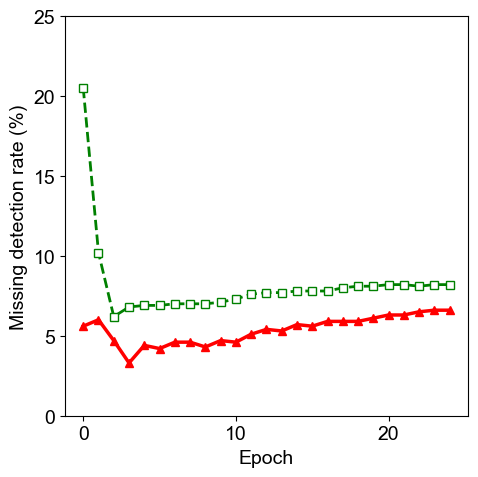

Figure saved to F:/ResearchProjects/RIPCODES/RipProject/Plots/Recall1.png at 600 dpi.


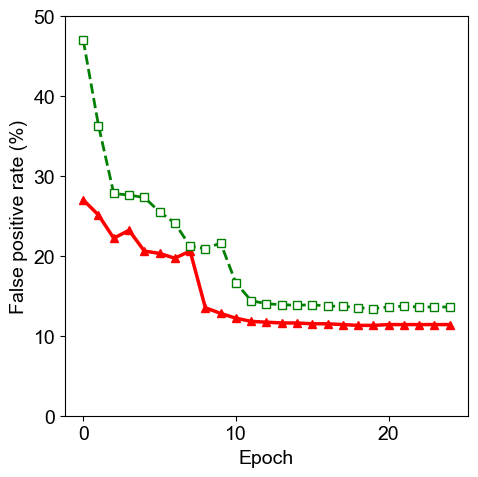

In [13]:
performance = pd.read_csv(r'F:\Dropbox\Prelim\Code_And_Data\chapter4\Data\Performance\EvalPerformance.csv')
# minus 1 to make the epoch start from 0
performance['Epoch'] = performance['Epoch'] - 1
for i in range(1, 5):
    performance.iloc[:, i] = 100 - performance.iloc[:, i]*100
# Epoch,Precision_Cascade_Refined,Precision_Cascade_Orig,Precision_Faster_RCNN,Recall_Cascade_Refined,Recall_Cascade_Orig,Recall_Faster_RCNN
mdp.plot_polylines(performance, 0, [1,3], 
               show_grid=False, legends=['Cascade RCNN W Ref','Cascade RCNN WO Ref','Faster RCNN'],
               line_styles={1: '-', 3: '--'},show_legend=False,
               line_widths={1: 2.5, 3: 2}, y_label='Missing detection Rate (%)',
               line_colors={1: 'red', 3: 'green'},
               marker_colors={1: 'red', 3:'white'}, 
               markers={1: '^', 3: 's'},
               fig_size=(5, 5), x_tick_interval=10, font_size=14, y_range=[0,25],
               save_path = 'F:/ResearchProjects/RIPCODES/RipProject/Plots/Precision1.png')

# Epoch,Precision_Cascade_Refined,Precision_Cascade_Orig,Precision_Faster_RCNN,Recall_Cascade_Refined,Recall_Cascade_Orig,Recall_Faster_RCNN
mdp.plot_polylines(performance, 0, [2,4], 
               show_grid=False, legends=['','',''],
               line_styles={2: '-', 4: '--', 6: '-.'}, show_legend=False,
               line_widths={2: 2.5, 4: 2, 6: 3}, y_label='False Positive Rate (%)',
               line_colors={2: 'red', 4: 'green', 6: 'blue'},
               marker_colors={2: 'red', 5: 'blue', 4:'white'},
               markers={6: 'o', 2: '^', 4: 's'},
               fig_size=(5, 5), x_tick_interval=10, font_size=14,y_range=[0, 50],
               save_path = 'F:/ResearchProjects/RIPCODES/RipProject/Plots/Recall1.png')

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


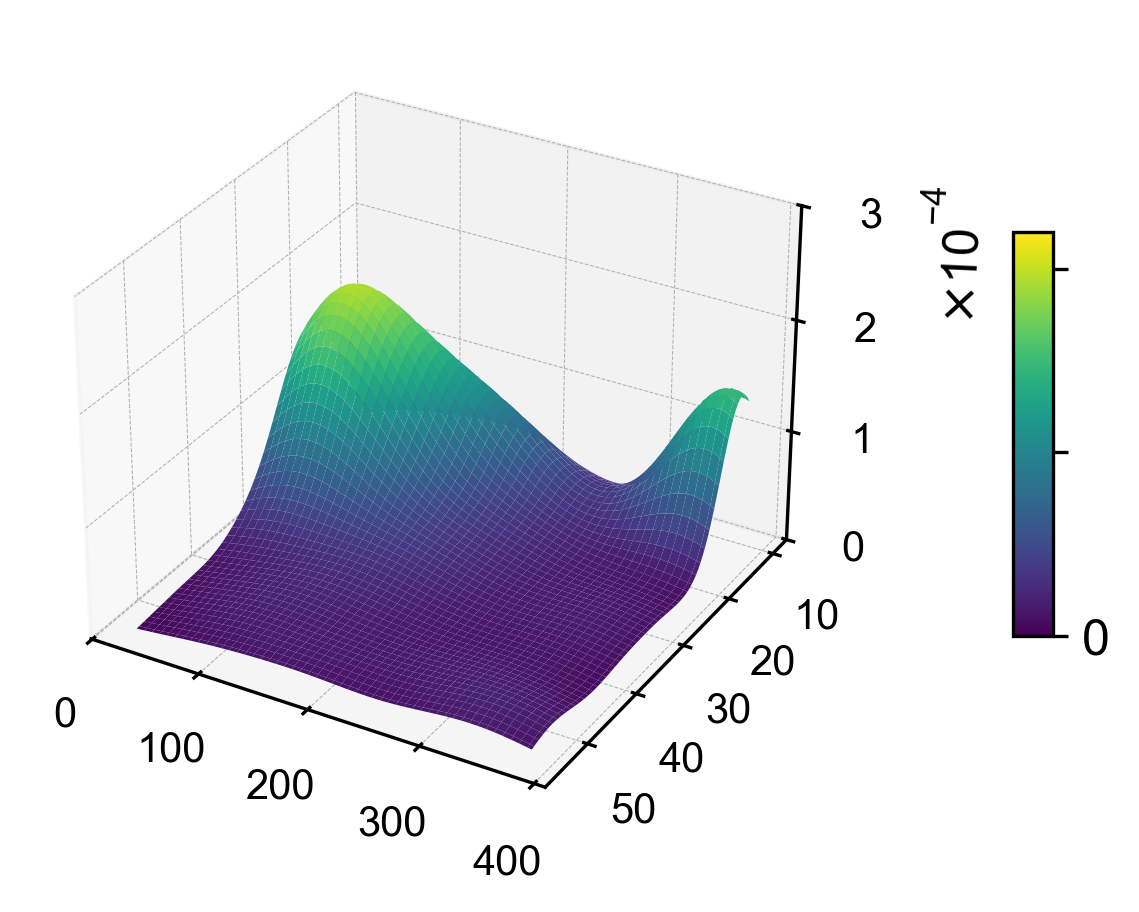

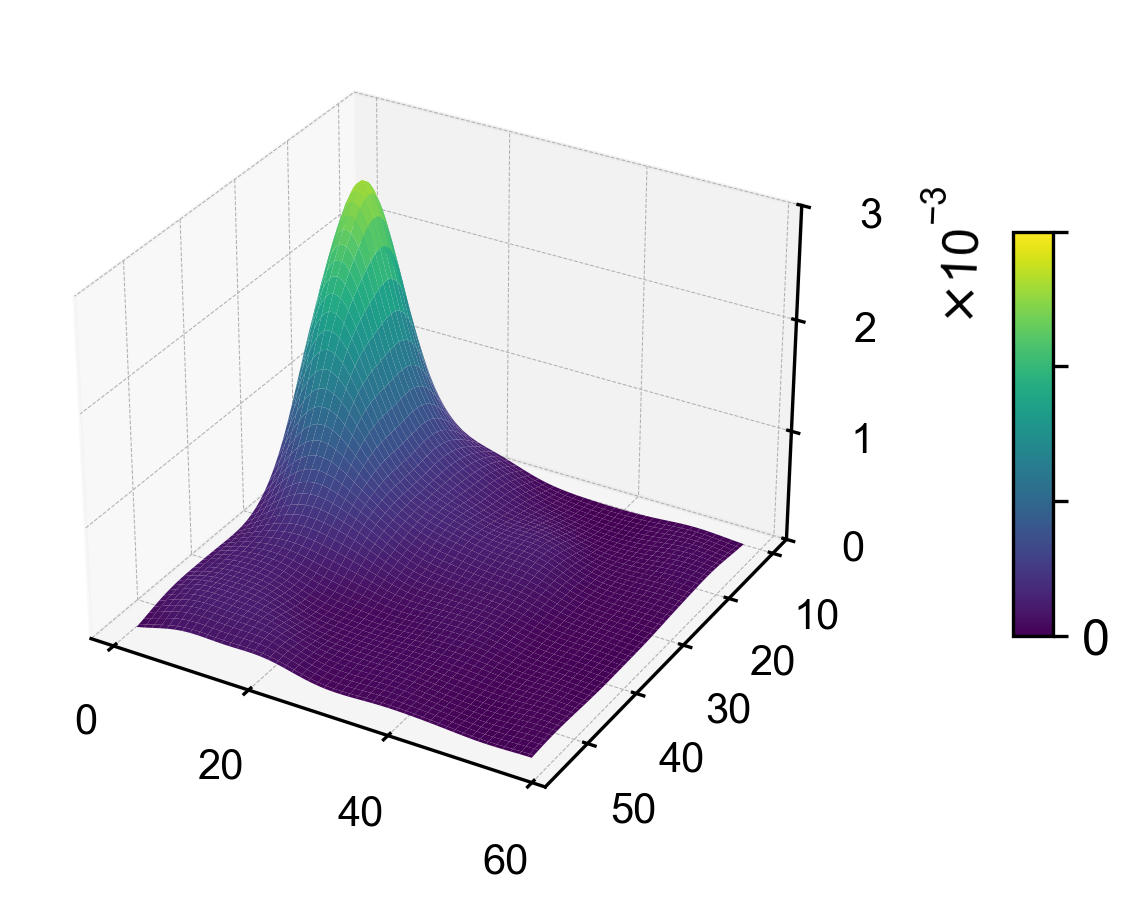

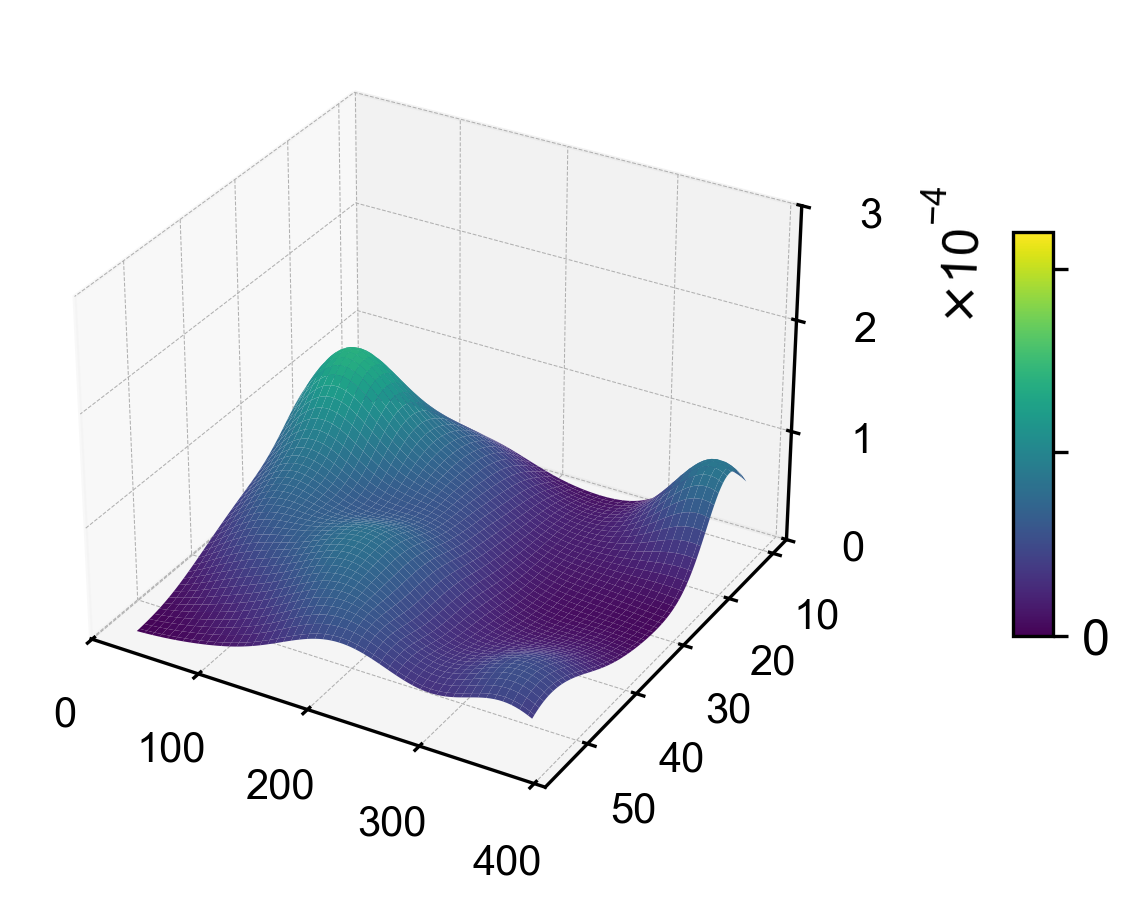

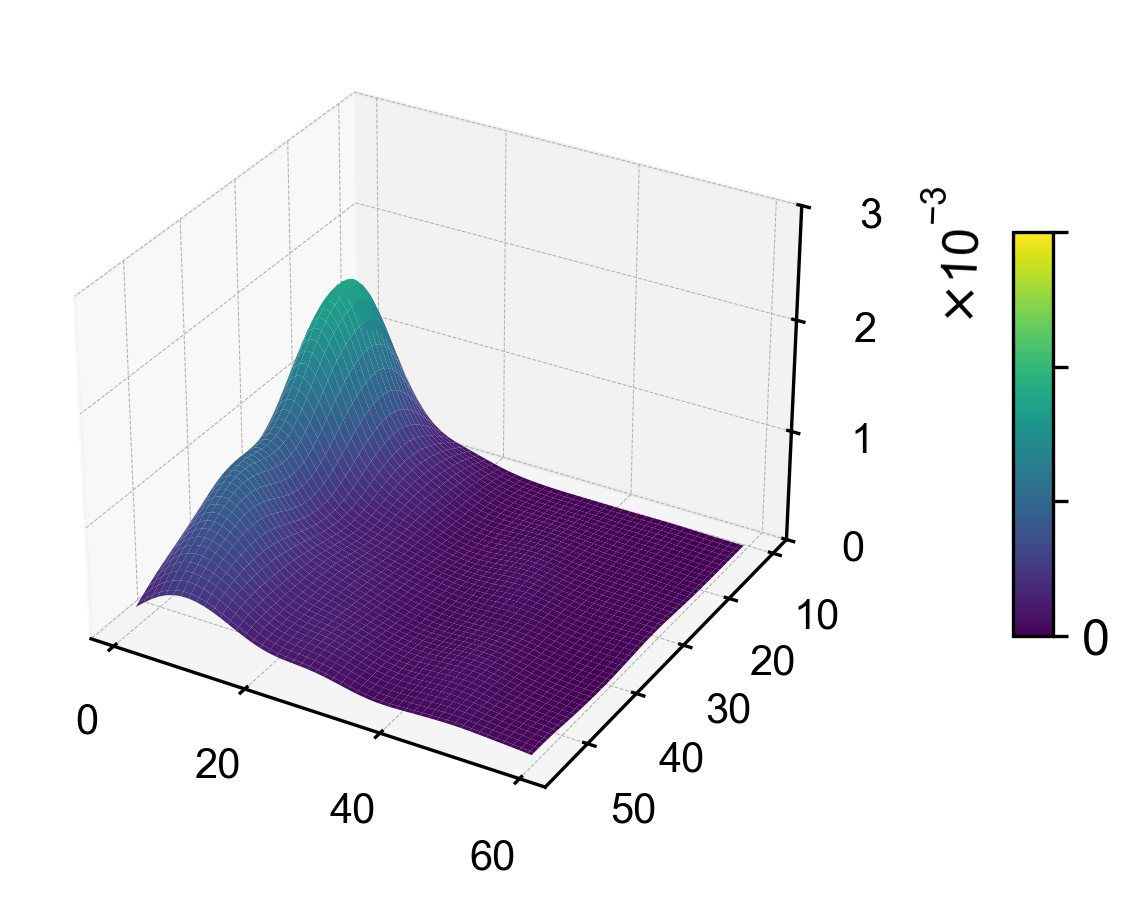

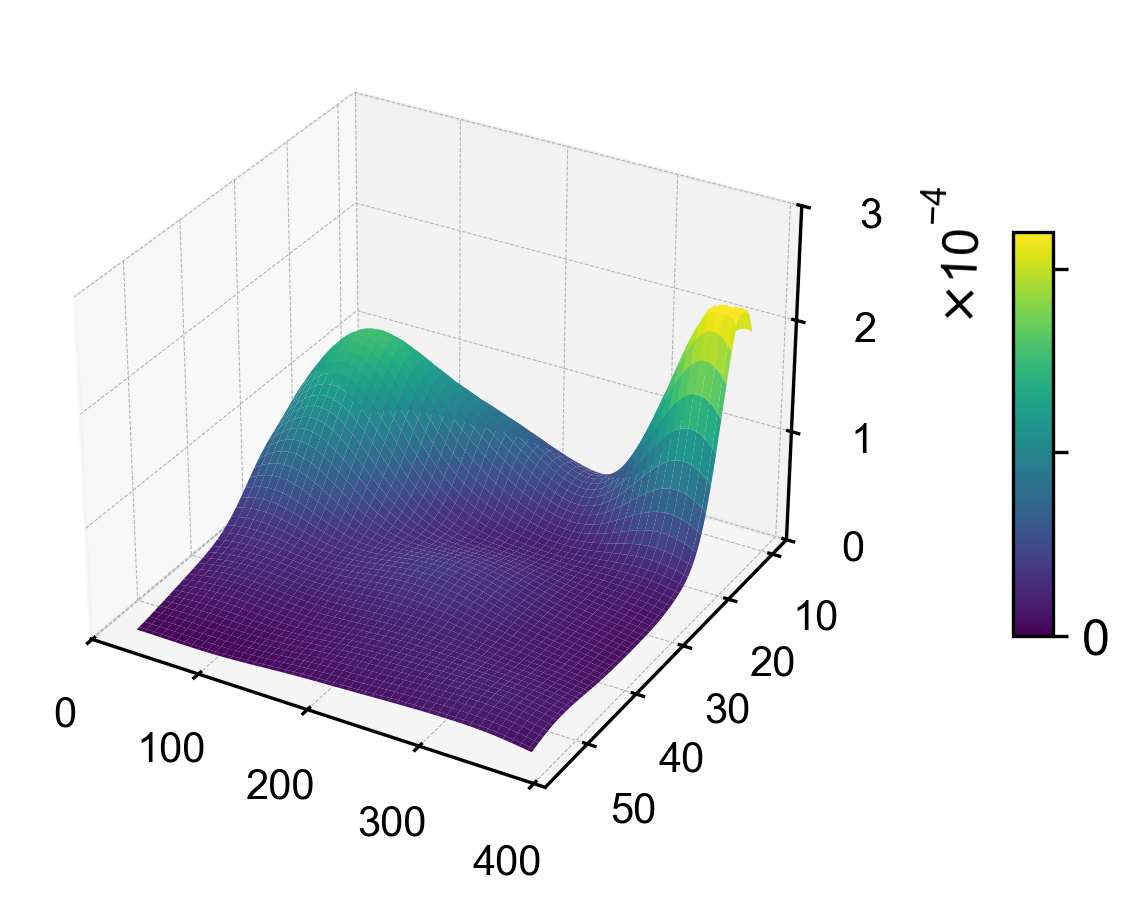

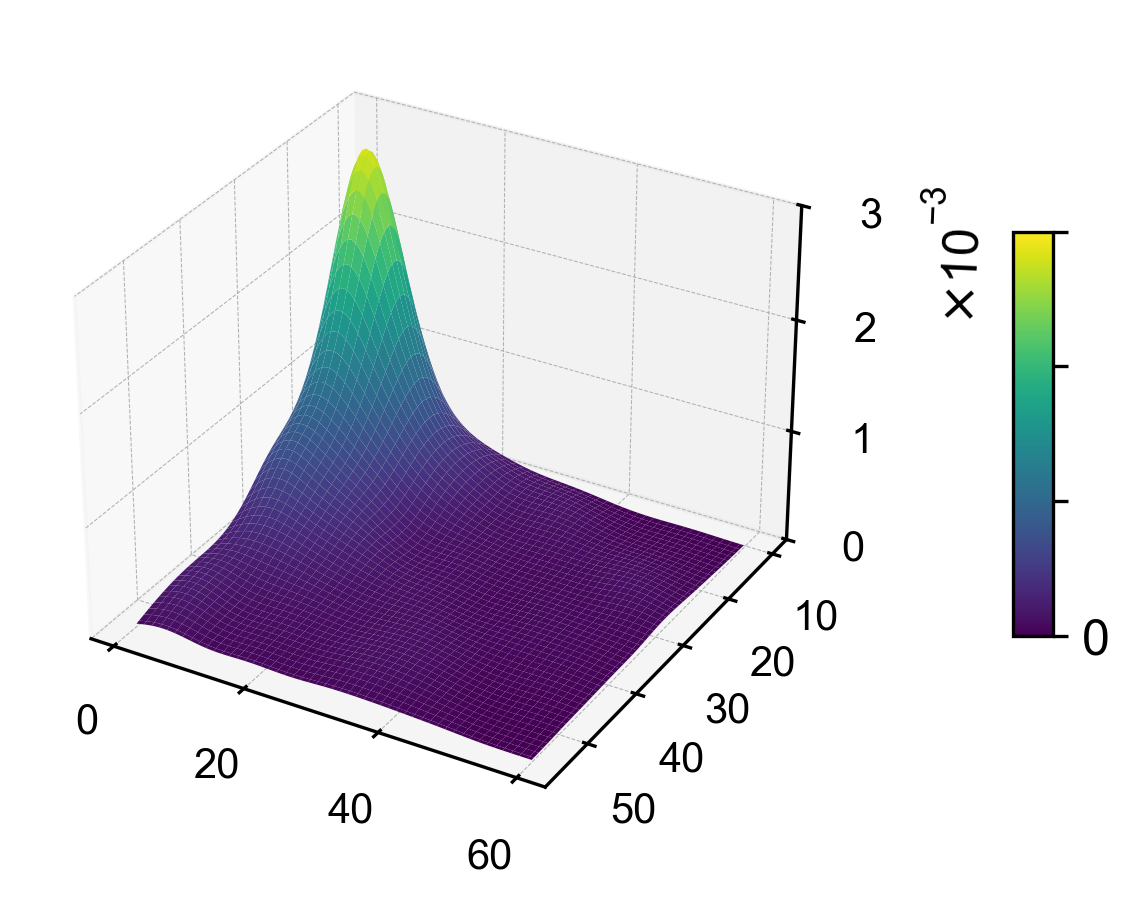

In [41]:
if_filtered = True
check_res_list = [WLF_final_res, Normal_final_res, Oblique_final_res]
for check_res in check_res_list:
    if if_filtered:
        check_res = [i for i in check_res if i.get('breaking_dist') >= 0]
    key_1, key_2 = 'max_dist', 'max_x_center'
    key_3, key_4 = 'max_dist', 'duration'
    mdp.plot_3d_density_surface(check_res, key_2, key_1, flip_y=True, zlim=(0,0.00022), z_interval=0.0001, figsize=(8,3.5), zlabel = '', x_scale_factor=10, y_scale_factor=10, is_legend=True, is_gridline=True, background_color='white')
    mdp.plot_3d_density_surface(check_res, key_4, key_3, flip_y=True, zlim=(0,0.003), z_interval=0.001, figsize=(8,3.5), zlabel = '',x_scale_factor=60, y_scale_factor=10, is_legend=True, is_gridline=True, background_color='white')
# input_pd = dict_list_to_dataframe(check_res, key_1, key_2)

# bin_ticks_1 = [14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
# bin_ticks_2 = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50]
# # bin_ticks_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5]

# # bin_ticks_2 = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# pair_freq = analyze_cross_relationship(check_res, key_1, key_2, \
#      key1_ticks = bin_ticks_1, key2_ticks = bin_ticks_2, x_scale = 10, y_scale = 60)
# # # normalize pair_freq to percentage
# # pair_freq = {key: val / len(check_res) * 100 for key, val in pair_freq.items()}
# # mdp.plot_2D_heatmap(pair_freq, bin_ticks_1, bin_ticks_2, xtick_rotation = 45, xlabel = 'max_dist (m)', ylabel = 'duration (s)', 
# #                     cbar_label = 'Frequency (%)',title = '', vmin = 0, vmax=5)
# # plot_contour_map(pair_freq)
# mdp.plot_3d_stacked_bar(pair_freq, bin_ticks_1, bin_ticks_2, fig_size = (180,10),xtick_rotation = 0, ytick_rotation=0, elevation = 30, azimuth = 15,
#                      zmin = 0, zmax = 9, xlabel = '', ylabel = '', zlabel = '', title = '', is_percent = True)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mticker

def plot_cdfs(data_lists, fig_size=(10, 6), line_styles=None, line_widths=None, is_percent=True,
              line_colors=None, legends=None, marker_colors=None, x_tick_interval=10, tick_label_fontsize=12,
              markers=None, show_grid=True, font_name='Arial', font_size=12, save_path=None,
              dpi=600, is_same_figure=True, is_log_x=False, regression_trans=None, title='Cumulative Distribution Function',
              show_reg_eqn=True, annno_digits=3, x_lim=None, x_label=None, y_label=None,
              labelpad=5, titlepad=10):
    """
    Plot the CDF for each set of data in data_lists with extensive customization options,
    including the option to plot all on the same figure or on individual subplots, and
    setting the x-axis to logarithmic scale. Additionally, performs OLS regression
    within specified ranges and plots the regression lines.
    """
    if is_same_figure:
        fig, ax = plt.subplots(figsize=fig_size)
    else:
        fig, axs = plt.subplots(len(data_lists), 1, figsize=fig_size)
    
    plt.rc('font', family=font_name, size=font_size)
    
    for i, data in enumerate(data_lists):
        sorted_data = np.sort(data)
        yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        
        if is_percent:
            yvals = yvals * 100
        style = line_styles.get(i, '-') if line_styles else '-'
        width = line_widths.get(i, 1) if line_widths else 1
        color = line_colors.get(i, 'b') if line_colors else 'b'
        marker = markers.get(i, None) if markers else None
        marker_color = marker_colors.get(i, color) if marker_colors else color
        legend = legends[i] if legends and i < len(legends) else f"Data {i+1}"

        current_ax = ax if is_same_figure else axs[i]
        
        if is_log_x:
            current_ax.set_xscale('log')
            current_ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
            current_ax.xaxis.set_minor_formatter(mticker.NullFormatter())
            current_ax.ticklabel_format(style='plain', axis='x')

        current_ax.plot(sorted_data, yvals, linestyle=style, linewidth=width, color=color,
                        marker=marker, markerfacecolor=marker_color, label=legend)
        
        # Regression analysis within specified ranges
        if regression_trans:
            for start, end in regression_trans:
                mask = (sorted_data >= start) & (sorted_data <= end)
                reg_data = sorted_data[mask]
                reg_yvals = yvals[mask]

                if len(reg_data) > 1:
                    reg_model = sm.OLS(reg_yvals, sm.add_constant(reg_data)).fit()
                    reg_line = reg_model.predict(sm.add_constant(reg_data))
                    current_ax.plot(reg_data, reg_line, linestyle='--', linewidth=width, color=color)
                    if show_reg_eqn:
                        b, m = reg_model.params
                        equation_text = f"$y = {m:.{annno_digits}f}x + {b:.{annno_digits}f}$"
                        x_pos = np.median(reg_data)
                        y_pos = np.interp(x_pos, reg_data, reg_line)
                        current_ax.annotate(equation_text, (x_pos, y_pos), textcoords="offset points",
                                            xytext=(0,10), ha='right', color=color, fontsize=font_size)
        
        if x_tick_interval and not is_log_x:
            current_ax.set_xticks(np.arange(0, 1.1, 1 / x_tick_interval))
        
        if x_lim:
            current_ax.set_xlim(x_lim)

        if show_grid:
            current_ax.grid(True)
        current_ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
        current_ax.legend()

        if x_label:
            current_ax.set_xlabel(x_label, fontsize=font_size, labelpad=labelpad)
        if y_label:
            current_ax.set_ylabel(y_label, fontsize=font_size, labelpad=labelpad)

    plt.title(title, pad=titlepad)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=dpi)
    
    plt.show()


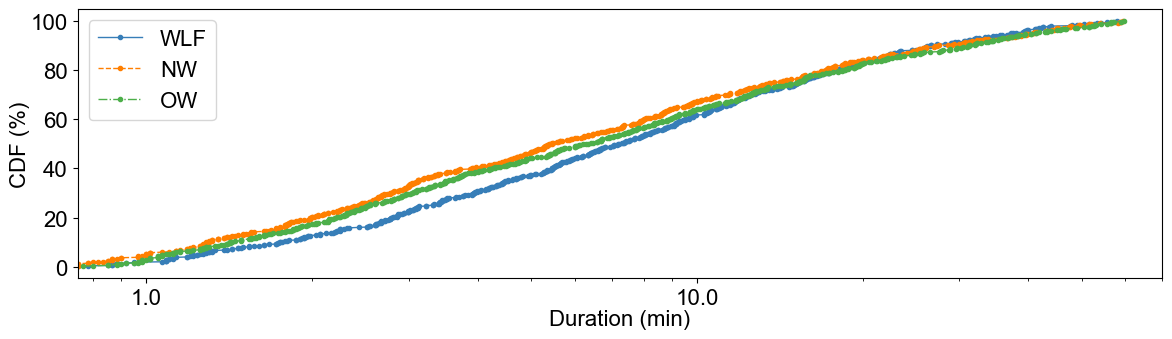

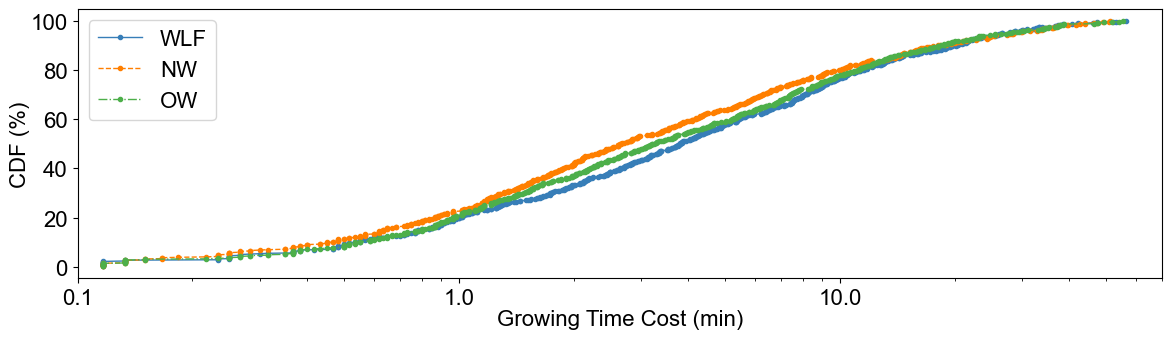

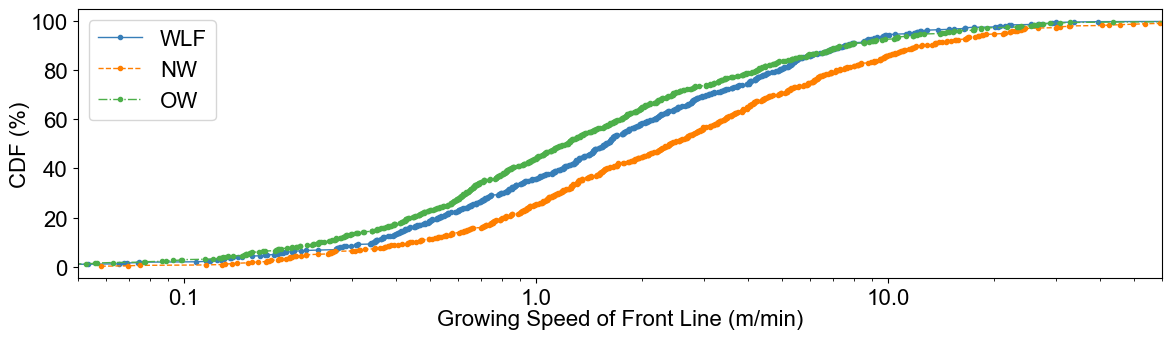

In [23]:
check_param_list = ['duration', 'peak_time_cost', 'speed']
# check_param_list = ['max_dist', 'max_x_center']
x_labels = ['Duration (min)', 'Growing Time Cost (min)', 'Growing Speed of Front Line (m/min)']
plot_folder = r'F:/ResearchProjects/RIPCODES/RipProject/Plots/'
scale = [60, 60, 10/60]
y_range = [(0, 16), (0, 15), (0, 25)]
x_lims = [(0.75, 70), (0.1, 70), (0.05, 60)]
for i in range(len(check_param_list)):
    check_param = check_param_list[i]
    hist_data_list = [create_hist_data(WLF_final_res, check_param), \
                    create_hist_data(Normal_final_res, check_param),\
                    create_hist_data(Oblique_final_res, check_param)]
    for j in range(len(hist_data_list)):
        hist_data_list[j] = [k / scale[i] for k in hist_data_list[j]]
       
    plot_cdfs(hist_data_list, line_styles={0: '-', 1: '--', 2: '-.', 3:'-'}, line_widths={1: 1, 2: 1, 3: 1, 4:1}, 
                line_colors={0: '#377eb8', 1: '#ff7f00', 2:  '#4daf4a', 3:'black'},x_lim=x_lims[i],
                marker_colors={0: '#377eb8', 1: '#ff7f00', 2: '#4daf4a', 3:'none'}, labelpad=0.5,
                legends = ['WLF', 'NW', 'OW'], title='', x_label = x_labels[i], y_label = 'CDF (%)',
                markers={0: '.', 1: '.', 2: '.', 3:'.'}, is_log_x = True, x_tick_interval=None,
                fig_size=(12, 4), show_grid = False, tick_label_fontsize=16,  font_size=16,
                save_path=plot_folder + 'CDF_%s.png' % check_param)
    


In [24]:
import numpy as np
from scipy.signal import butter, filtfilt

def highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

def check_key_properties(data, key):
    """
    Check the properties of a key in a list of dictionaries.
    """
    values = [d[key] for d in data]
    print("Max value for key '%s': %f" % (key, max(values)))
    print("Min value for key '%s': %f" % (key, min(values)))
    print("Mean value for key '%s': %f" % (key, np.mean(values)))
    print("Standard deviation for key '%s': %f" % (key, np.std(values)))
    print("Median value for key '%s': %f" % (key, np.median(values)))
    print("Number of NaN values for key '%s': %d" % (key, np.isnan(values).sum()))



In [44]:
is_test=True;
if is_test:# for this cell, let us deal with sensitivity
    pickle_folder = "";
    sensitivity_params = ["wave_right_boundary", "angle_range", "target_depth"]
    group_nums = [1, 2, 3];
    sensitivity_sums = {}
    for i in range(3):
        temp_sums = {}
        for j in range(3):
            save_folder = "F:/Dropbox/Prelim/Code_And_Data/chapter4/Data/Pickle/"
            save_name = "final_res_2019-05-15_2019-09-13-%s-%d"%(sensitivity_params[i], group_nums[j]);
            with open(save_folder + save_name, 'rb') as f:
                final_res = pickle.load(f)
            f.close()    

            WLF_final_res = [i for i in final_res if i.get('Classification_V3') == 1]
            Oblique_final_res = [i for i in final_res if i.get('Classification_V3') == 3]
            Normal_final_res = [i for i in final_res if i.get('Classification_V3') == 2]
            Other_final_res = [i for i in final_res if i.get('Classification_V3') == 4]
            temp_counts = [len(WLF_final_res), len(Normal_final_res), len(Oblique_final_res), len(Other_final_res)]
            temp_pie_data = [100*len(WLF_final_res)/len(final_res), 100*len(Normal_final_res)/len(final_res), 100*len(Oblique_final_res)/len(final_res), 100*len(Other_final_res)/len(final_res)]
            temp_max_dists = [np.nanmean([j.get('max_dist') for j in WLF_final_res]), np.nanmean([j.get('max_dist') for j in Normal_final_res]), np.nanmean([j.get('max_dist') for j in Oblique_final_res]), np.mean([j.get('max_dist') for j in Other_final_res])]
            temp_max_x_centers = [np.nanmean([j.get('max_x_center') for j in WLF_final_res]), np.nanmean([j.get('max_x_center') for j in Normal_final_res]), np.nanmean([j.get('max_x_center') for j in Oblique_final_res])]
            temp_duration = [np.mean([j.get('duration') for j in WLF_final_res]), np.mean([j.get('duration') for j in Normal_final_res]), np.mean([j.get('duration') for j in Oblique_final_res])]
            temp_peak_time_cost = [np.mean([j.get('peak_time_cost') for j in WLF_final_res]), np.mean([j.get('peak_time_cost') for j in Normal_final_res]), np.mean([j.get('peak_time_cost') for j in Oblique_final_res])]
            temp_sums[str(group_nums[j])] = {"count":temp_counts, "pie_data":temp_pie_data, "max_dist":temp_max_dists, "max_x_center":temp_max_x_centers, "duration":temp_duration, "peak_time_cost":temp_peak_time_cost}
        sensitivity_sums[f"{sensitivity_params[i]}"] = temp_sums


In [45]:
sensitivity_sums

{'wave_right_boundary': {'1': {'count': [577, 585, 621, 114],
   'pie_data': [30.416447021613074,
    30.838165524512387,
    32.73589878755931,
    6.009488666315234],
   'max_dist': [262.90205966413953,
    308.39268686669504,
    222.82497471119854,
    374.16419427436693],
   'max_x_center': [1697.1068222375338,
    1811.1355370747563,
    2089.7940510428616],
   'duration': [689.4558058925477, 634.1521367521367, 674.6666666666666],
   'peak_time_cost': [448.35701906412476,
    395.04102564102567,
    414.8341384863124]},
  '2': {'count': [607, 578, 598, 114],
   'pie_data': [31.997891407485504,
    30.46916183447549,
    31.523458091723775,
    6.009488666315234],
   'max_dist': [256.7473635602822,
    310.52056899285236,
    226.0066571570559,
    374.16419427436693],
   'max_x_center': [1758.0782411319726, 1800.0716074187274, 2055.037039903469],
   'duration': [677.1878088962109, 636.780276816609, 683.3628762541806],
   'peak_time_cost': [439.12850082372324,
    396.626297577854

In [46]:
print(sum([j.get('max_x_center') for j in WLF_final_res]) / len(WLF_final_res))
print(sum([j.get('max_x_center') for j in Normal_final_res]) / len(Normal_final_res))
print(sum([j.get('max_x_center') for j in Oblique_final_res]) / len(Oblique_final_res))


1729.3648176745864
1771.1773905223413
2073.740089702592


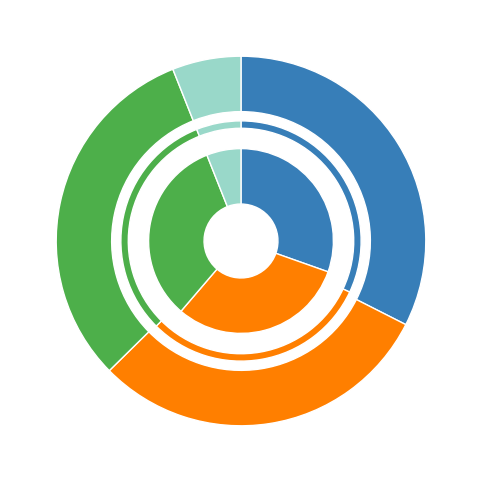

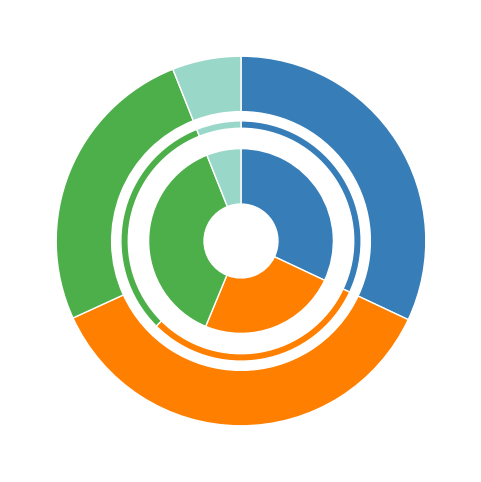

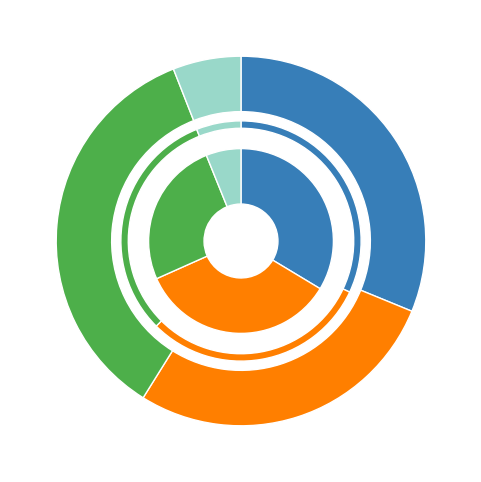

In [26]:
import matplotlib.pyplot as plt
if is_test:
       # Data for all three pie charts (same segments for alignment)
       labels = ['','','','']
       params = ["wave_right_boundary", "angle_range", "target_depth"]
       for param in params:
              sizes = [sensitivity_sums.get(param).get(str(j+1)).get('pie_data') for j in range(3)]  # Ensure all have the same number of segments
              colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9']  # Define consistent colors

              # Define figure and axis
              fig, ax = plt.subplots(figsize=(6,6))

              # Outer circle (Largest), rotate clockwisely
              ax.pie(sizes[2], labels=labels, radius=1, startangle=90, colors=colors,
                     wedgeprops=dict(width=0.3, edgecolor='white'), counterclock=False)

              # Middle circle (Thin)
              ax.pie(sizes[1], radius=0.65, startangle=90, colors=colors,
                     wedgeprops=dict(width=0.04, edgecolor='white'), counterclock=False)

              # Inner circle (Smallest)
              ax.pie(sizes[0], radius=0.5, startangle=90, colors=colors,
                     wedgeprops=dict(width=0.3, edgecolor='white'), counterclock=False)

              # Equal aspect ratio ensures the pie is drawn as a circle
              ax.set_aspect('equal')

              plt.show()



[[26.29020597 30.83926869 22.28249747]
 [25.67473636 31.0520569  22.60066572]
 [25.56334212 31.17393096 22.63755411]]
[[25.67473636 32.00218065 23.38307805]
 [25.67473636 31.0520569  22.60066572]
 [25.67473636 30.77012154 21.13261961]]
[[25.3195069  30.99526679 21.537426  ]
 [25.67473636 31.0520569  22.60066572]
 [25.82199961 31.30158408 23.01145648]]


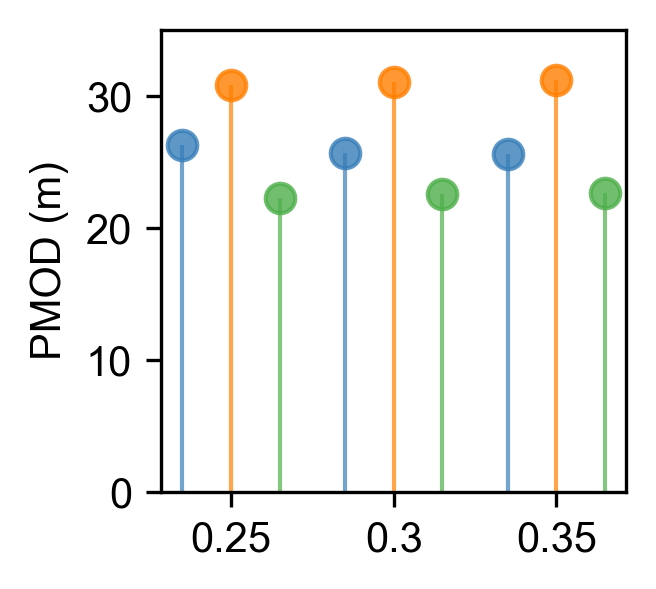

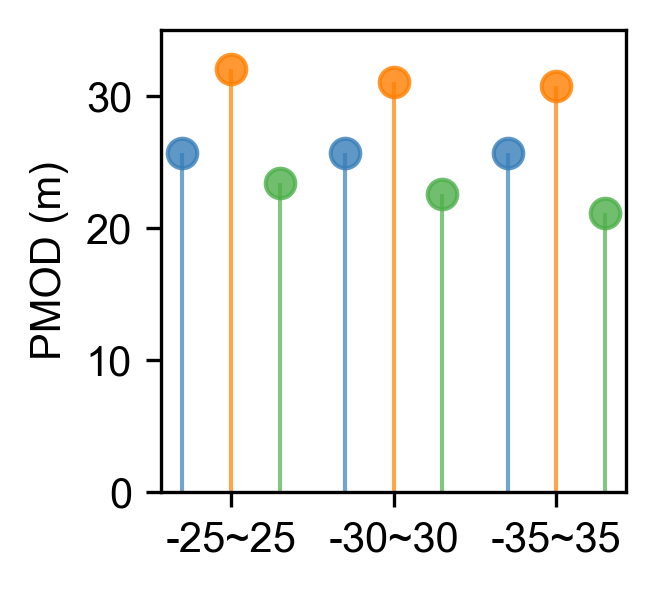

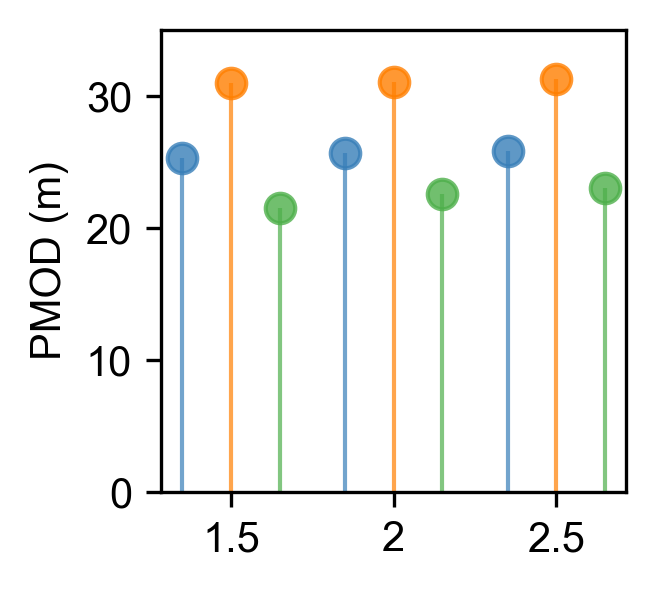

In [44]:
if is_test:
    labels = ['','','','']
    y_label = 'PMOD (m)'
    y_key = 'max_dist'
    y_scale = 10
    matrix1 = np.array([sensitivity_sums.get(sensitivity_params[0]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    matrix2 = np.array([sensitivity_sums.get(sensitivity_params[1]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    matrix3 = np.array([sensitivity_sums.get(sensitivity_params[2]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9']  # Define consistent colors
    print(matrix1)
    print(matrix2)
    print(matrix3)
    mdp.plot_new_grouped_dot_chart(matrix1, ['0.25', '0.3', '0.35'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,35],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)
    mdp.plot_new_grouped_dot_chart(matrix2, ['-25~25', '-30~30', '-35~35'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,35],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)
    mdp.plot_new_grouped_dot_chart(matrix3, ['1.5', '2', '2.5'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,35],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)

[[169.71068222 181.11355371 208.9794051 ]
 [175.80782411 180.00716074 205.50370399]
 [175.58894729 179.57123497 206.34145412]]
[[175.80782411 176.86255683 203.32203597]
 [175.80782411 180.00716074 205.50370399]
 [175.80782411 178.1377018  213.74059277]]
[[178.8486262  178.21635108 210.6993818 ]
 [175.80782411 180.00716074 205.50370399]
 [172.93648177 177.11773905 207.37400897]]


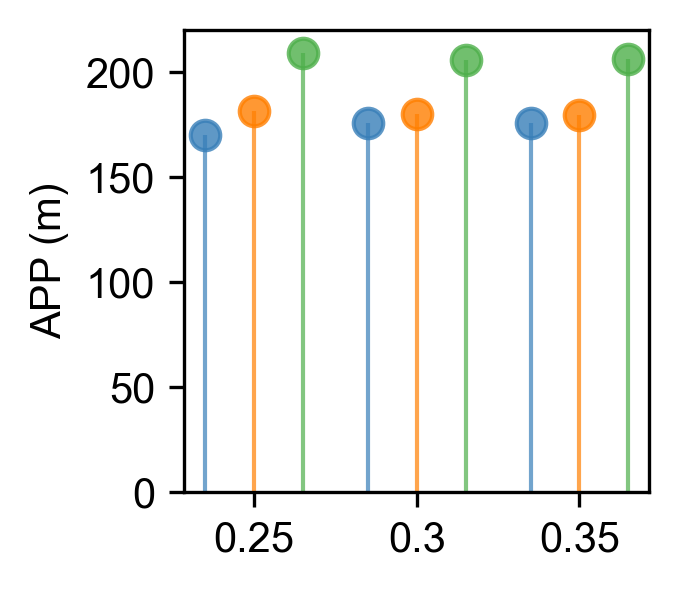

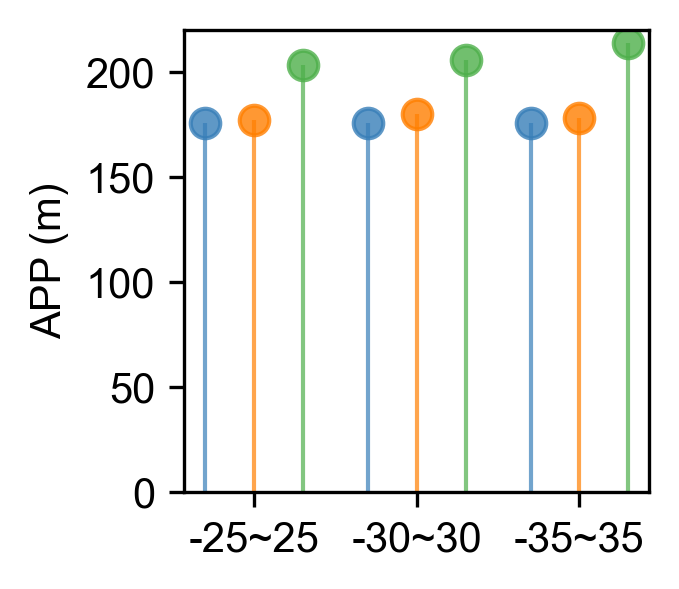

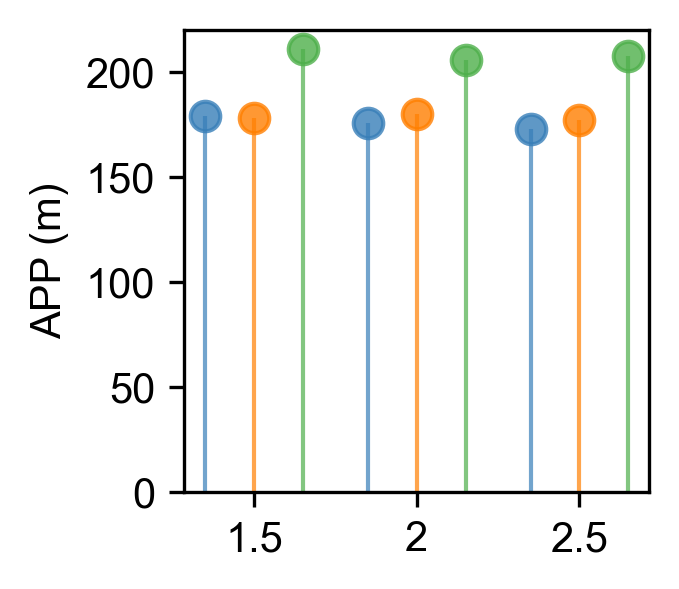

In [28]:
if is_test:
    labels = ['','','','']
    y_label = 'APP (m)'
    y_key = 'max_x_center'
    y_scale = 10
    matrix1 = np.array([sensitivity_sums.get(sensitivity_params[0]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    matrix2 = np.array([sensitivity_sums.get(sensitivity_params[1]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    matrix3 = np.array([sensitivity_sums.get(sensitivity_params[2]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9']  # Define consistent colors
    print(matrix1)
    print(matrix2)
    print(matrix3)
    mdp.plot_new_grouped_dot_chart(matrix1, ['0.25', '0.3', '0.35'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,220],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)
    mdp.plot_new_grouped_dot_chart(matrix2, ['-25~25', '-30~30', '-35~35'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,220],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)
    mdp.plot_new_grouped_dot_chart(matrix3, ['1.5', '2', '2.5'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,220],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)

[[11.4909301  10.56920228 11.24444444]
 [11.28646348 10.61300461 11.38938127]
 [11.36858766 10.53175991 11.37619048]]
[[11.28646348 10.4084058  11.39287709]
 [11.28646348 10.61300461 11.38938127]
 [11.28646348 10.66071429 11.49370748]]
[[11.09516719 10.74171733 11.56113402]
 [11.28646348 10.61300461 11.38938127]
 [11.31143018 10.51593651 11.36424288]]


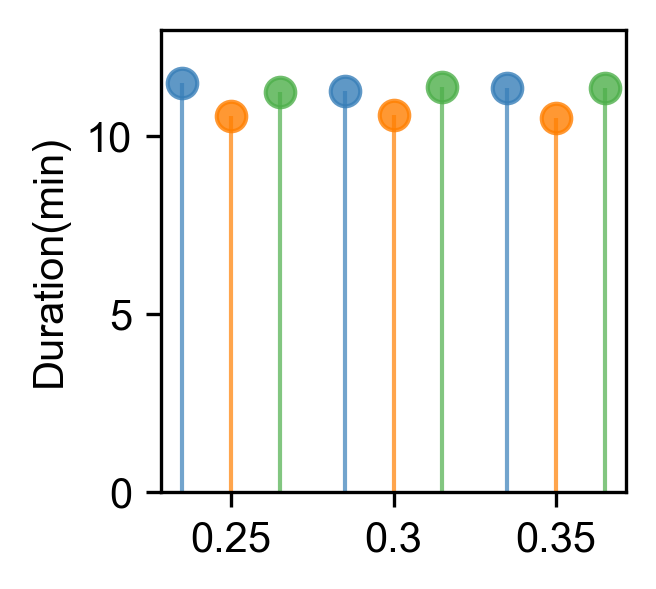

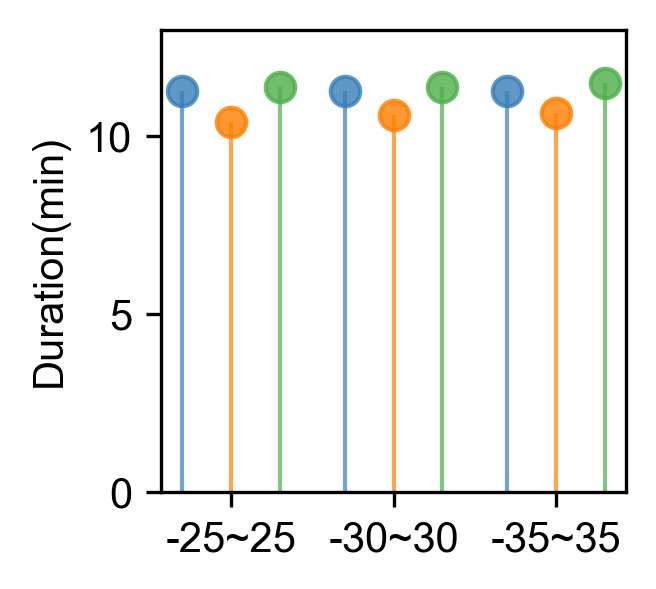

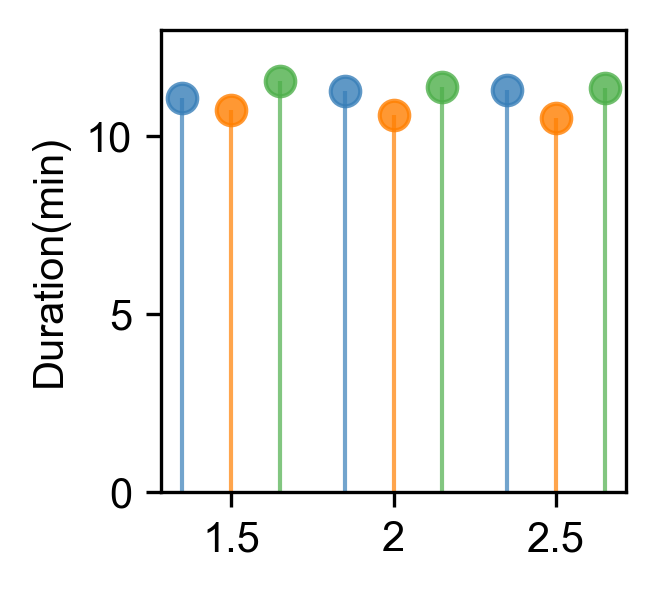

In [45]:
if is_test:
    labels = ['','','','']
    y_label = 'Duration(min)'
    y_key = 'duration'
    y_scale = 60
    matrix1 = np.array([sensitivity_sums.get(sensitivity_params[0]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    matrix2 = np.array([sensitivity_sums.get(sensitivity_params[1]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    matrix3 = np.array([sensitivity_sums.get(sensitivity_params[2]).get(str(j+1)).get(y_key) for j in range(3)])/y_scale
    colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9']  # Define consistent colors
    print(matrix1)
    print(matrix2)
    print(matrix3)
    mdp.plot_new_grouped_dot_chart(matrix1, ['0.25', '0.3', '0.35'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,13],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)
    mdp.plot_new_grouped_dot_chart(matrix2, ['-25~25', '-30~30', '-35~35'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,13],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)
    mdp.plot_new_grouped_dot_chart(matrix3, ['1.5', '2', '2.5'], ['WLF', 'NW', 'OW'], dot_size=50, dot_alpha=0.8, cmap='tab20',
        xlabel='', ylabel=y_label, title=None, fontsize=10, tick_fontsize=10, tick_rotation=0,colors = ['#377eb8', '#ff7f00', '#4daf4a', '#99d8c9'],
        x_interval=None, y_interval=None, y_log_scale=False, y_sci_notation=False,
        grid_style="--", grid_alpha=0.5, grid_linewidth=0.5, is_grid=False,ylim=[0,13],
        font_name='Arial', is_legend=False, is_show=True, fig_size=(2, 2), dpi=300, save_path=None)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_dual_histogram(data1, data2, bins=45, fig_size=(4,5),
                        scale_factor1=10, scale_factor2=10,
                        xlabel="Distance (m)", ylabel="Percentage (%)", title="",
                        tick_size=15, label_size=15, title_size=16, y_range=None,
                        color1='blue', color2='red', linewidth=2, labels=['Data 1', 'Data 2'],
                        dpi=600, save_path=None):
    """
    Plots two overlapping histograms with separated edges, using percentage on the y-axis.
    Ensures y-axis shows only integer ticks.
    """

    # Scale the data
    data1 = np.array(data1) / scale_factor1
    data2 = np.array(data2) / scale_factor2

    # Define bins based on combined scaled data range
    bin_edges = np.histogram_bin_edges(np.concatenate((data1, data2)), bins=bins)

    # Compute histogram values as percentages
    hist1, _ = np.histogram(data1, bins=bin_edges, weights=np.ones(len(data1)) / len(data1) * 100)
    hist2, _ = np.histogram(data2, bins=bin_edges, weights=np.ones(len(data2)) / len(data2) * 100)

    # Offset amount based on linewidth
    offset = linewidth / 2

    # Convert bins into step-format edges
    bin_edges_step = np.repeat(bin_edges, 2)[1:-1]
    new_bin_edges = bin_edges_step + offset
    old_bin_edges = bin_edges_step - offset
    hist1_edges = np.repeat(hist1, 2)
    hist2_edges = np.repeat(hist2, 2)

    # Create figure
    plt.figure(figsize=fig_size, dpi=dpi)

    # Plot the histograms
    plt.plot(old_bin_edges, hist1_edges, color=color1, linewidth=linewidth, label=labels[0])
    plt.plot(new_bin_edges, hist2_edges, color=color2, linewidth=linewidth, label=labels[1])

    # Set y-axis range if provided
    if y_range:
        plt.ylim(y_range)

    # Set y-axis to integer ticks only
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Customization
    plt.xlabel(xlabel, fontsize=label_size)
    plt.ylabel(ylabel, fontsize=label_size)
    plt.title(title, fontsize=title_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)

    # Add legend
    plt.legend(loc='upper center')

    # Save or show plot
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [56]:
check_param_list = ['max_dist', 'max_x_center']
check_param = "max_x_center"
hist_data_list1 = [create_hist_data(WLF_final_res, check_param), create_hist_data(Normal_final_res, check_param), \
                  create_hist_data(Oblique_final_res, check_param)]
check_type = ['x', 'y']
y_range = [(0, 9.5), (0, 7.8)]
is_include_whole = False
c = 'x'
hist_data_list2 = [get_max_box_list(WLF_final_res, return_type = c, max_x_thresh=250), get_max_box_list(Normal_final_res, return_type = c, max_x_thresh=250), \
                  get_max_box_list(Oblique_final_res, return_type = c, max_x_thresh=250)]
plot_folder = r'F:/ResearchProjects/RIPCODES/RipProject/Plots/'
# Sample data
for i in range(3):
    data1 = hist_data_list1[i]
    data2 = hist_data_list2[i]
    plot_path = plot_folder + 'histogram_X%d.jpg'%i

    plot_dual_histogram(data2, data1, labels = ['AP', 'APP'], y_range=(-0.05,15.9), xlabel="Position (m)",color1 = "#b2182b", color2="#2166ac",linewidth=1,
                        save_path=plot_path)


In [57]:
check_param_list = ['max_dist', 'max_x_center']
check_param = "max_dist"
hist_data_list1 = [create_hist_data(WLF_final_res, check_param), create_hist_data(Normal_final_res, check_param), \
                  create_hist_data(Oblique_final_res, check_param)]
check_type = ['x', 'y']
y_range = [(0, 9.5), (0, 7.8)]
is_include_whole = False
c = 'y'
hist_data_list2 = [get_max_box_list(WLF_final_res, return_type = c, max_x_thresh=250), get_max_box_list(Normal_final_res, return_type = c, max_x_thresh=250), \
                  get_max_box_list(Oblique_final_res, return_type = c, max_x_thresh=250)]

# Sample data
for i in range(3):
    data1 = hist_data_list1[i]
    data2 = hist_data_list2[i]
    plot_path = plot_folder + 'histogram_Y%d.jpg'%i

    plot_dual_histogram(data2, data1, labels = ['OD', 'PMOD'], y_range=(-0.05,11.5), xlabel="Distance (m)",color1 = "#b2182b", color2="#2166ac",linewidth=1,
                        save_path=plot_path)


In [ ]:
print(sum([j.get('max_x_center') for j in WLF_final_res]) / len(WLF_final_res))
print(sum([j.get('max_x_center') for j in Normal_final_res]) / len(Normal_final_res))
print(sum([j.get('max_x_center') for j in Oblique_final_res]) / len(Oblique_final_res))
print(sum([j.get('duration') for j in WLF_final_res]) / len(WLF_final_res))
print(sum([j.get('duration') for j in Normal_final_res]) / len(Normal_final_res))
print(sum([j.get('duration') for j in Oblique_final_res]) / len(Oblique_final_res))


1758.0782411319726
1800.0716074187274
2055.037039903469
677.1878088962109
636.780276816609
683.3628762541806


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

def center_wrap(text, width):
    """
    Wrap text to a given width with center justification.
    Returns a string with \n separating each line.
    """
    import textwrap
    lines = textwrap.wrap(text, width=width)
    return '\n'.join(line.center(width) for line in lines)

def plot_bar_from_lists(values, labels, 
                        title="Bar Plot", xlabel="Categories", ylabel="Values",
                        rotation=45, color="skyblue", edgecolor="black",
                        fontsize=12, figsize=(10, 6), save_path=None,
                        text_width=None):
    """
    Plots a bar chart from numerical values and corresponding labels.

    Parameters:
    - values: List of numerical values.
    - labels: List of corresponding labels (same length as values).
    - title: Title of the plot.
    - xlabel, ylabel: Axis labels.
    - rotation: Degree of x-tick rotation.
    - color: Bar color.
    - edgecolor: Bar edge color.
    - fontsize: Font size for labels and title.
    - figsize: Tuple for figure size.
    - save_path: If provided, saves the plot to this path.
    - text_width: If set, wraps labels wider than this width with center justification.
    """
    if len(values) != len(labels):
        raise ValueError("Length of values and labels must be equal.")

    if text_width:
        wrapped_labels = [center_wrap(str(label), text_width) for label in labels]
    else:
        wrapped_labels = labels

    plt.figure(figsize=figsize)
    plt.bar(wrapped_labels, values, color=color, edgecolor=edgecolor)
    plt.title(title, fontsize=fontsize + 2)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(rotation=rotation, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
def plot_pairwise_bar(labels, values1, values2, 
                      label1='Group 1', label2='Group 2',
                      title='Pairwise Bar Plot', xlabel='Categories', ylabel='Values',
                      rotation=45, color1='skyblue', color2='salmon', y_range=None,
                      edgecolor='black', fontsize=12, figsize=(10, 6),
                      text_width=None, save_path=None):
    """
    Plots a pairwise (grouped) bar chart for two sets of values with the same labels.

    Parameters:
    - labels: List of shared category labels.
    - values1, values2: Two lists of numerical values (same length as labels).
    - label1, label2: Legend labels for the two groups.
    - text_width: If set, wraps and center-aligns labels wider than this width.
    """
    if not (len(labels) == len(values1) == len(values2)):
        raise ValueError("All input lists must have the same length.")

    if text_width:
        wrapped_labels = [center_wrap(str(label), text_width) for label in labels]
    else:
        wrapped_labels = labels

    x = np.arange(len(labels))  # label locations
    width = 0.35                # width of each bar

    plt.figure(figsize=figsize)
    plt.bar(x - width/2, values1, width, label=label1, color=color1, edgecolor=edgecolor)
    plt.bar(x + width/2, values2, width, label=label2, color=color2, edgecolor=edgecolor)

    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title(title, fontsize=fontsize + 2)
    plt.xticks(ticks=x, labels=wrapped_labels, rotation=rotation, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    if y_range:
        plt.ylim(y_range)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

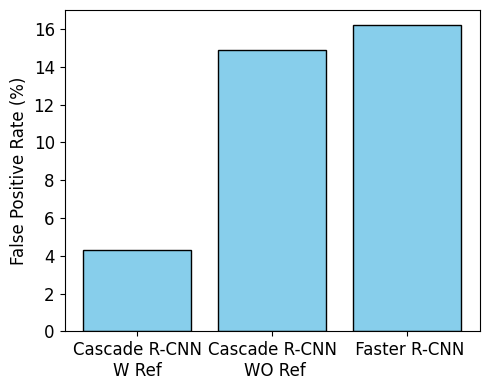

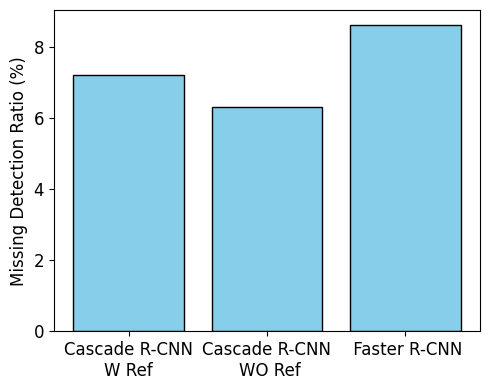

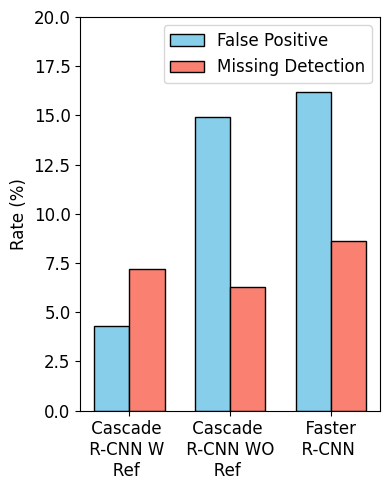

In [7]:
values1 = [4.3, 14.9, 16.2]
values2 = [7.2, 6.3, 8.6]
labels = ['Cascade R-CNN W Ref', 'Cascade R-CNN WO Ref', 'Faster R-CNN']
plot_bar_from_lists(values1, labels, title="", ylabel="False Positive Rate (%)", xlabel="",text_width=13, rotation=0,fontsize=12, figsize=(5, 4),)
plot_bar_from_lists(values2, labels, title="", ylabel="Missing Detection Ratio (%)", xlabel="",text_width=13, rotation=0,fontsize=12, figsize=(5, 4),)
plot_pairwise_bar(labels, values1, values2, label1='False Positive', label2='Missing Detection',
                  title='', xlabel='', ylabel='Rate (%)', rotation=0, fontsize=12, figsize=(4, 5), text_width=10,y_range=(0, 20),
                  save_path=None)